In [3]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

# Control figure size
figsize=(14, 4)

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os

%load_ext autoreload
%autoreload 2

from util import util_ad_hd as util

# Load data
data_file = os.path.join('..', 'data', 'hpc.csv')
hpc = pd.read_csv(data_file, parse_dates=['timestamp'])

# Identify input columns
inputs = hpc.columns[1:-1]
ninputs = len(inputs)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Anomaly Detection in HPC Centers

## High Performance Computing

**High Performance Computing**

HPC refers to HW/SW infrastructures for particularly intensive workloads

<center><img src="assets/Marconi100.jpg" width=60%/></center>

## High Performance Computing

**HPC is (somewhat) distinct from cloud computing**

* Cloud computing is mostly about running (and scaling) _services_
* ...HPC is all about _performance_

Typical applications: simulation, massive data analysis, training large ML models

**HPC systems follow a _batch computation_ paradigm**

* Users send _jobs_ to the systems (i.e. configuration for running a program)
* Jobs end in one of several _queues_
* A _job scheduler_ draws from the queue
* ...And dispatches jobs to computational _nodes_ for execution

## High Performance Computing

**HPC systems can be large and complex**

E.g. Leonardo, 7-th on the top 500 list on [June 2024](https://top500.org/lists/top500/2024/06/)

<center><img src="assets/top500.png" width=60%/></center>

* The system has 1,824,768 cores overall!

**Configuring (and maintaining the configuration) of these systems**

* ...Is of paramount importance, as it has an impact on the performance
* ...Is challenging, due to their _scale_ and the presence of _node heterogeneity_ 

Hence the interest in _detecting anomalous conditions_


## The Dataset

**As an example, we will consider the DAVIDE system**

Small scale, energy-aware architecture:

* Top of the line components (at the time), liquid cooled
* An advanced monitoring and control infrastructure (ExaMon)
* ...Developed together with UniBo

The system went out of production in January 2020

**The monitoring system enables anomaly detection**

* Data is collected from a number of samples with high-frequency
* Long term storage only for averages over 5 minute intervals
* Anomalies correspond to unwanted configurations of the _frequency governor_
* ...Which can throttle performance to save power or prevent overheating

## A Look at the Dataset

**Our dataset refers to the non-idle periods of a single node**

In [4]:
print(f'#examples: {hpc.shape[0]}, #columns: {hpc.shape[1]}')
hpc.iloc[:3]

#examples: 6667, #columns: 161


,timestamp,ambient_temp,cmbw_p0_0,cmbw_p0_1,cmbw_p0_10,cmbw_p0_11,cmbw_p0_12,cmbw_p0_13,cmbw_p0_14,cmbw_p0_2,...,util_p0_5,util_p0_6,util_p0_8,util_p0_9,volt_v0_1,volt_v0_2,volt_v1_1,volt_v1_2,winkcnt_p0_2,anomaly
0,2018-03-05 22:45:00,0.165639,0.006408,0.012176,0.166835,0.238444,0.230092,0.145691,0.227682,0.000094,...,0.056146,0.007334,0.009948,0.015761,0.076402,0.727967,0.075536,0.787213,1.0,0
1,2018-03-05 22:50:00,0.139291,0.007772,0.057400,0.166863,0.238485,0.230092,0.145691,0.227682,0.176855,...,0.998460,0.742089,0.010209,0.019240,0.999908,0.727514,0.999856,0.787024,1.0,0
2,2018-03-05 22:55:00,0.141048,0.000097,0.000000,0.166863,0.238444,0.230092,0.145691,0.227682,0.252403,...,0.239957,0.838108,0.010262,0.025894,0.999918,0.727514,0.999870,0.787024,1.0,0


* This still a time series, but a _multivariate_ one

## A Look at the Dataset

**How to display multivariate series? Approach #1: showing _individual columns_**

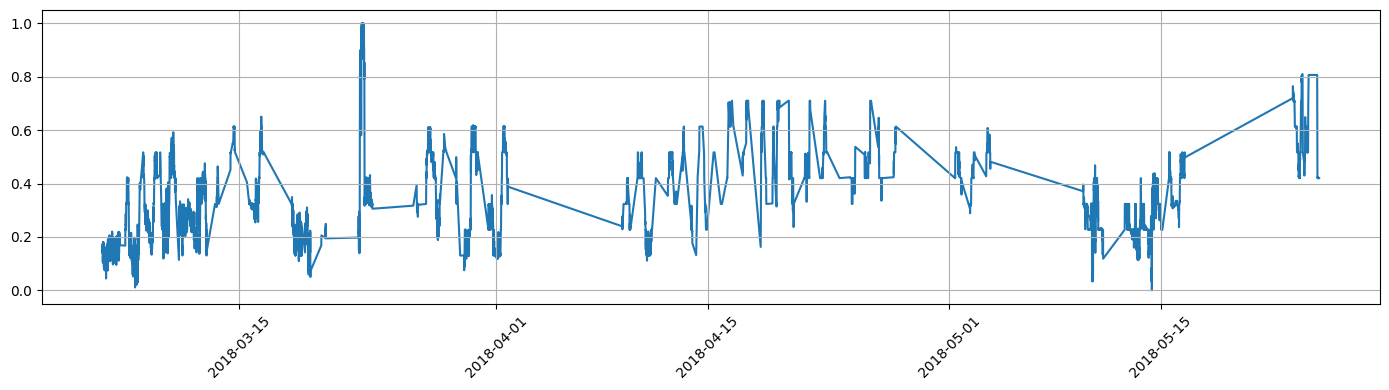

In [5]:
tmp = pd.Series(index=hpc['timestamp'], data=hpc[inputs[0]].values)
util.plot_series(tmp, figsize=figsize)

* The series contains significant gaps (i.e. the idle periods)

## A Look at the Dataset

**Approach #2: obtaining _statistics_**

In [6]:
hpc[inputs].describe()

,ambient_temp,cmbw_p0_0,cmbw_p0_1,cmbw_p0_10,cmbw_p0_11,cmbw_p0_12,cmbw_p0_13,cmbw_p0_14,cmbw_p0_2,cmbw_p0_3,...,util_p0_4,util_p0_5,util_p0_6,util_p0_8,util_p0_9,volt_v0_1,volt_v0_2,volt_v1_1,volt_v1_2,winkcnt_p0_2
count,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,...,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000
mean,0.357036,0.138162,0.060203,0.119616,0.160606,0.184970,0.118305,0.151434,0.143033,0.147800,...,0.509612,0.716533,0.766818,0.202598,0.202650,0.808665,0.481398,0.808170,0.512920,0.626519
std,0.166171,0.128474,0.090796,0.098597,0.128127,0.163190,0.104490,0.120793,0.125052,0.138610,...,0.479815,0.424887,0.400454,0.388927,0.389502,0.386906,0.379362,0.387440,0.400457,0.483765
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.227119,0.000073,0.000020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000117,0.000056,...,0.000200,0.198757,0.678980,0.000000,0.000000,0.999887,0.000000,0.999827,0.000000,0.000000
50%,0.323729,0.136095,0.000082,0.166835,0.238444,0.230092,0.145691,0.227682,0.174933,0.138148,...,0.517715,0.999260,0.999380,0.010074,0.009918,0.999908,0.727514,0.999856,0.787024,1.000000
75%,0.470254,0.261908,0.134976,0.166984,0.238566,0.230406,0.145908,0.227779,0.251910,0.299604,...,0.999523,0.999828,0.999907,0.016749,0.023519,0.999928,0.727514,0.999885,0.787024,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


* No missing value, _normalized_ data

## A Look at the Dataset

**Approach #3: standardize, then use a _heatmap_**

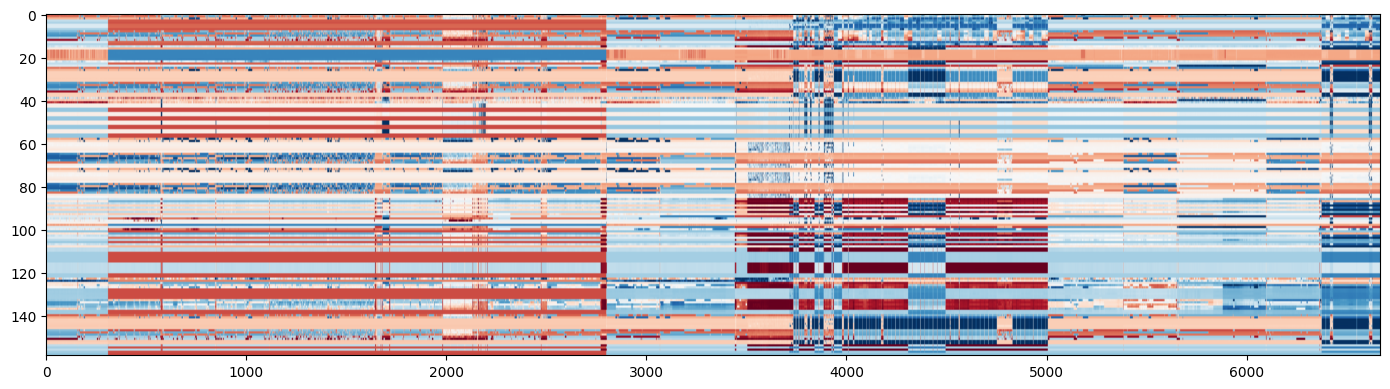

In [7]:
hpcsv = hpc.copy()
hpcsv[inputs] = (hpcsv[inputs] - hpcsv[inputs].mean()) / hpcsv[inputs].std()
util.plot_dataframe(hpcsv[inputs], figsize=figsize)

* White = mean, red = below mean, blue = above mean

## Anomalies

**There are three possible configurations of the frequency governor:**

* Mode 0 or "normal": frequency proportional to the workload
* Mode 1 or "power saving": frequency always at the minimum value
* Mode 2 or "performance": frequency always at the maximum value

**On this dataset, this information is known**

...And it will serve as our ground truth

* We will focus on discriminating normal from non-normal behavior
* I.e. we will treat both "power saving" and "performance" cases as anomalous

**Detecting them will be _challenging_**

* Since the signals vary so much when the running job changes

## Anomalies

**We can plot the location of the anomalies:**

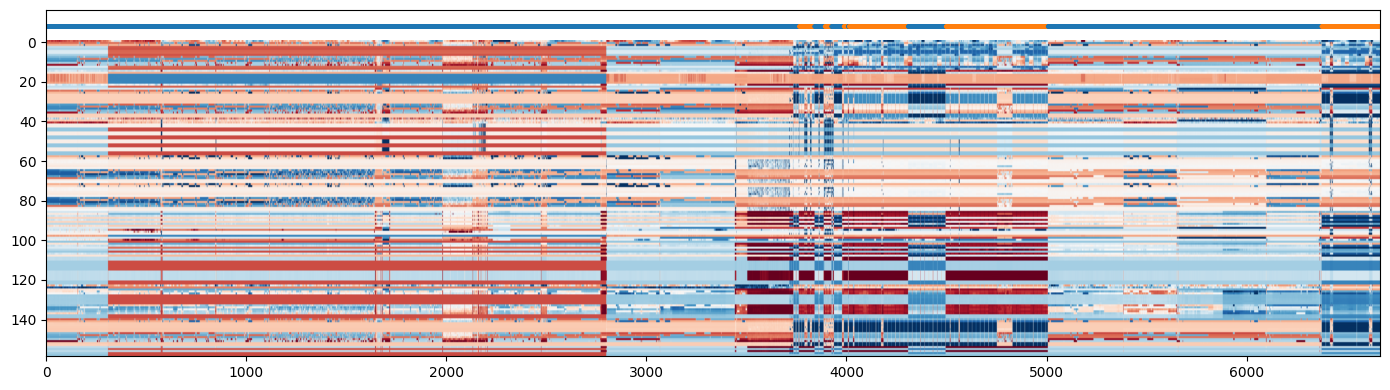

In [8]:
labels = pd.Series(index=hpcsv.index, data=(hpcsv['anomaly'] != 0), dtype=int)
util.plot_dataframe(hpcsv[inputs], labels, figsize=figsize)

* On the top, blue = normal, orange = anomaly

# A KDE Approach

##  KDE Approach

**Let's try first a density estimation approach (once again using KDE)**

First, we _standardize_ the data again, based on _training information alone_

In [9]:
tr_end, val_end = 3000, 4500

hpcs = hpc.copy()
tmp = hpcs.iloc[:tr_end]
hpcs[inputs] = (hpcs[inputs] - tmp[inputs].mean()) / tmp[inputs].std()

* This is needed so that we do not accidentally exploit test set information
* The training set separator was chosen so as not to include anomalies

**Then we can separate training, validation, and test data:**

In [10]:
trdata = hpcs.iloc[:tr_end]
valdata = hpcs.iloc[tr_end:val_end]
tsdata = hpcs.iloc[val_end:]

## A KDE Approach

**Then we calibrate the bandwidth and generate the alarm signal**

In [11]:
%%time
opt = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': np.linspace(0.1, 1, 10)}, cv=5)
opt.fit(trdata[inputs])
print(f'Best parameters: {opt.best_params_}')

ldens = opt.score_samples(hpcs[inputs])
signal_kde = pd.Series(index=hpcs.index, data=-ldens)

Best parameters: {'bandwidth': 0.5}
CPU times: user 9.24 s, sys: 65.4 ms, total: 9.31 s
Wall time: 9.3 s


> **Both operations are relatively expensive: why?**

## KDE Approach

**There is _a good match_ with the anomalies, but also some _spurious peaks_**

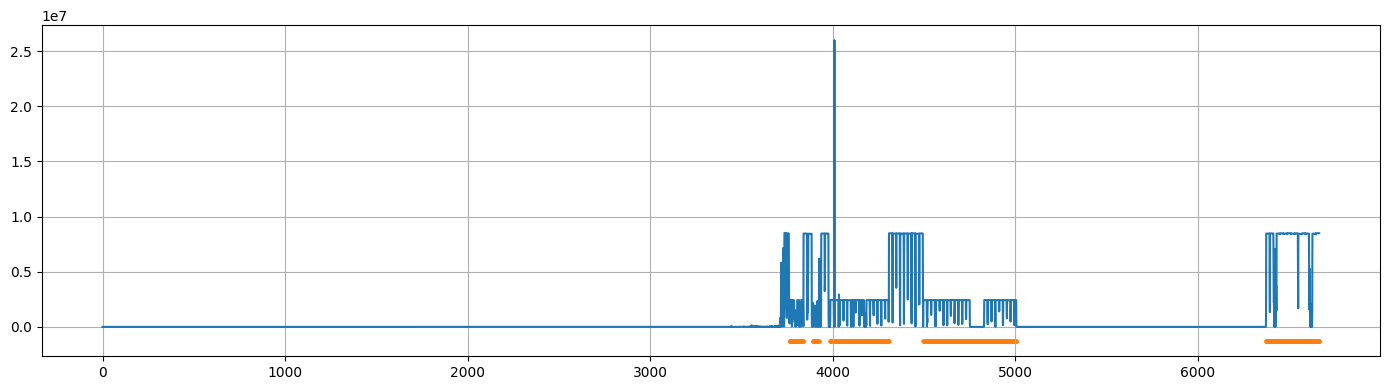

In [12]:
util.plot_signal(signal_kde, labels, figsize=figsize)

* This is mostly due to the large variations due to job changes

## KDE Approach

**We then need to define the threshold, but for that we need a cost model**

Our main goal is to detect anomalies, not anticipating them

* Misconfigurations in HPC are usually not critical 
* ...And cause little issue, unless they stay unchecked for very long

**We will use a simple _cost model_:**

* $c_{\mathit{alarm}}$ for false positive (erroneous detections)
* $c_{\mathit{missed}}$ for false negatives (undetected anomalies)
* Detections are fine as long as they are within $\mathit{tolerance}$ units from the anomaly

In [13]:
c_alarm, c_missed, tolerance = 1, 5, 12
cmodel =  util.HPCMetrics(c_alarm, c_missed, tolerance)

The implementation details can be found in the `util` utility module

## KDE Approach

**We can now optimize the threshold over the validation set**

In [14]:
th_range = np.linspace(1e4, 2e5, 200)
th_kde, val_cost_kde = util.opt_threshold(signal_kde[tr_end:val_end],
                                        valdata['anomaly'],
                                        th_range, cmodel)
print(f'Best threshold: {th_kde:.3f}')
tr_cost_kde = cmodel.cost(signal_kde[:tr_end], hpcs['anomaly'][:tr_end], th_kde)
print(f'Cost on the training set: {tr_cost_kde}')
print(f'Cost on the validation set: {val_cost_kde}')
ts_cost_kde = cmodel.cost(signal_kde[val_end:], hpcs['anomaly'][val_end:], th_kde)
print(f'Cost on the test set: {ts_cost_kde}')

Best threshold: 148442.211
Cost on the training set: 0
Cost on the validation set: 263
Cost on the test set: 265


* The `opt_threshold` function runs the usual line search process
* In this case the training and validation set are completely separated

## The Trouble with KDE

**KDE-based approaches work well, but have some _issues_**

First, KDE itself runs into trouble with _high-dimensional data_:

* With a larger dimensionality, _prediction times_ grows...
* ...And _more data_ is needed to obtain reliable results

Second, KDE has trouble with _large training sets_

* The more the samples in the training set
* ...The more the terms to be summed to obtain a density

Third, KDE gives you _nothing more_ than an anomaly signal

* Determining the cause of the anomaly is up to a domain expert
* This is ok in low-dimensional spaces, but _harder on high-dimensional ones_